# Usher trees and metadata

This notebook explores data available [from the usher team](http://hgdownload.soe.ucsc.edu/goldenPath/wuhCor1/UShER_SARS-CoV-2/). Before running this notebook, run
```sh
scripts/pull_usher.sh  # takes <1 minute
```

In [1]:
import os
import re
import datetime
import pickle
from collections import Counter, defaultdict
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt
import tqdm
from pyrocov.mutrans import START_DATE
from pyrocov.usher import load_proto
from pyrocov import pangolin

matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["figure.facecolor"] = "white"

In [2]:
# Copied from scripts/preprocess_usher.py
DATE_FORMATS = {7: "%Y-%m", 10: "%Y-%m-%d"}

def try_parse_date(string):
    fmt = DATE_FORMATS.get(len(string))
    if fmt is not None:
        return datetime.datetime.strptime(string, fmt)

In [3]:
df = pd.read_csv("results/usher/metadata.tsv", sep="\t", dtype=str)
df

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher
0,100002|LR824035.1|2020-03-05,LR824035.1,2020-03-05,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
1,100003|LR824038.1|2020-03-04,LR824038.1,2020-03-04,Switzerland,Homo sapiens,NaN,29903,20B,B.1.1,20B,B.1.1
2,100004|LR824040.1|2020-03-06,LR824040.1,2020-03-06,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
3,100005|LR824037.1|2020-03-06,LR824037.1,2020-03-06,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
4,100006|LR824041.1|2020-03-06,LR824041.1,2020-03-06,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
...,...,...,...,...,...,...,...,...,...,...,...
3722943,tiger/USA/Tiger3-VA/2021|MZ305031.1|2021-04-13,MZ305031.1,2021-04-13,USA,Panthera tigris,NaN,29712,"20I (Alpha, V1)",B.1.1.7,"20I (Alpha,V1)",B.1.1.7
3722944,tiger/USA/tiger-2-040420/2020|MT704313.1|2020-...,MT704313.1,2020-04-04,USA,Panthera tigris,NaN,29872,20C,B.1,20C,B.1
3722945,tiger/USA/tiger-3-040420/2020|MT704315.1|2020-...,MT704315.1,2020-04-04,USA,Panthera tigris,NaN,29863,20C,B.1,20C,B.1
3722946,tiger/USA/tiger-4-040420/2020|MT704316.1|2020-...,MT704316.1,2020-04-04,USA,Panthera tigris,NaN,29834,20C,B.1,20C,B.1


In [4]:
by_date = sorted(
    (d, p)
    for (d, p) in zip(df["date"], df["pangolin_lineage"])
    if isinstance(d, str) and isinstance(p, str)
    if len(d) > 4
    if p not in ["A", "B", "A.1", "B.1"]
)
by_date[:10]

[('2020-01', 'B.42'),
 ('2020-01-05', 'B.1.375'),
 ('2020-01-07', 'B.1.2'),
 ('2020-01-14', 'B.1.1.7'),
 ('2020-01-20', 'B.1.2'),
 ('2020-01-20', 'B.1.258'),
 ('2020-01-21', 'B.1.2'),
 ('2020-01-23', 'A.6'),
 ('2020-01-24', 'B.4'),
 ('2020-01-24', 'B.4')]

In [5]:
df2 = pd.read_csv("results/nextstrain/metadata.tsv", sep="\t", dtype=str)
df2

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,QC_rare_mutations,QC_snp_clusters,QC_frame_shifts,QC_stop_codons,frame_shifts,deletions,insertions,substitutions,aaSubstitutions,clock_deviation
0,?,ncov,EPI_ISL_8303487,OV377246,ERR7904006,?,Europe,United Kingdom,?,NaN,...,bad,good,good,good,NaN,6513-6515,"22195:NTAGTGCGT,25695:GAA","C241T,A2832G,C3037T,C7124T,G8393A,G9441T,C1002...","M:I82T,ORF1a:K856R,ORF1a:L2084I,ORF1a:P2287S,O...",?
1,ARG/Cordoba-1006-155/2020,ncov,?,MW553298,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,good,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",4.0
2,ARG/Cordoba-1083-6/2020,ncov,?,MW553296,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,good,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",5.0
3,ARG/Cordoba-11300-61/2020,ncov,?,MW553301,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,good,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",2.0
4,ARG/Cordoba-11301-61/2020,ncov,?,MW553314,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,good,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3464347,mink/USA/WI-CDC-3892924-001/2020,ncov,?,MW626382,NaN,2020-10-15,North America,USA,USA,NaN,...,mediocre,good,mediocre,good,ORF6:23-62,"27267-27268,29816-29821",NaN,"C241T,C1059T,C3037T,A5877G,A10875G,T11968C,C14...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:N1871S,ORF1a...",-1.0
3464348,mink/USA/WI-CDC-3892928-001/2020,ncov,EPI_ISL_1014952,MW626383,NaN,2020-10-15,North America,USA,USA,NaN,...,mediocre,good,good,good,NaN,29816-29821,NaN,"C241T,C1059T,C3037T,A5877G,A10875G,T11968C,C14...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:N1871S,ORF1a...",-1.0
3464349,mink/USA/WI-CDC-3892938-001/2020,ncov,EPI_ISL_1014953,MW626384,NaN,2020-10-15,North America,USA,USA,NaN,...,mediocre,good,good,good,NaN,29816-29821,NaN,"C241T,C1059T,C2675T,C3037T,A5877G,A10875G,T119...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:P804S,ORF1a:...",1.0
3464350,mouse/CHN/MP7/2021,ncov,?,OM062573,NaN,2021-05-01,Asia,China,Beijing,NaN,...,mediocre,good,good,good,NaN,"11288-11296,22283-22291",NaN,"T3C,G174T,C241T,C1059T,A2692T,C3037T,C3817T,C3...","E:T30I,E:P71L,N:T205I,ORF1a:T265I,ORF1a:P1220L...",0.0


In [6]:
df2.columns

Index(['strain', 'virus', 'gisaid_epi_isl', 'genbank_accession',
       'sra_accession', 'date', 'region', 'country', 'division', 'location',
       'region_exposure', 'country_exposure', 'division_exposure', 'segment',
       'length', 'host', 'age', 'sex', 'Nextstrain_clade', 'pango_lineage',
       'GISAID_clade', 'originating_lab', 'submitting_lab', 'authors', 'url',
       'title', 'paper_url', 'date_submitted', 'sampling_strategy',
       'missing_data', 'divergence', 'nonACGTN', 'rare_mutations',
       'reversion_mutations', 'potential_contaminants', 'QC_missing_data',
       'QC_mixed_sites', 'QC_rare_mutations', 'QC_snp_clusters',
       'QC_frame_shifts', 'QC_stop_codons', 'frame_shifts', 'deletions',
       'insertions', 'substitutions', 'aaSubstitutions', 'clock_deviation'],
      dtype='object')

In [7]:
l = df["genbank_accession"].tolist()
print(repr(l[:8]))

['LR824035.1', 'LR824038.1', 'LR824040.1', 'LR824037.1', 'LR824041.1', 'LR824039.1', 'LR824042.1', 'LR824046.1']


In [8]:
ids1 = set(df["genbank_accession"].tolist())

In [9]:
ids2 = set(df2["genbank_accession"].tolist())

In [10]:
print(len(ids1), len(ids2))
print(len(ids1 & ids2), len(ids1 - ids2), len(ids2 - ids1))

3259510 3464352
0 3259510 3464352


In [11]:
ids12 = {i.split(".")[0] for i in ids1 if isinstance(i, str)}
print(len(ids12 & ids2), len(ids12 - ids2), len(ids2 - ids12))

3201727 57770 262625


In [12]:
ids21 = {i + ".1" for i in ids2}
print(len(ids1 & ids21), len(ids1 - ids21), len(ids21 - ids1))

3197553 61957 266799


In [13]:
Counter(i.split(".", 1)[1] for i in ids1 if isinstance(i, str))

Counter({'1': 3255323, '2': 4068, '3': 107, '4': 11})

In [14]:
versions = defaultdict(set)
for i in ids1:
    if isinstance(i, str):
        lhs, rhs = i.split(".")
        versions[lhs].add(rhs)
Counter(map(len, versions.values()))

Counter({1: 3259485, 2: 12})

In [15]:
dates = df2["date"].tolist()
Counter(map(len, dates))

Counter({1: 711, 10: 3432670, 4: 22259, 7: 8712})

In [16]:
start_date = try_parse_date(START_DATE)
days = Counter()
for string in dates:
    date = try_parse_date(string)
    if date is not None:
        days[(date - start_date).days] += 1

In [17]:
with open("results/stats.pkl", "rb") as f:
    stats = pickle.load(f)

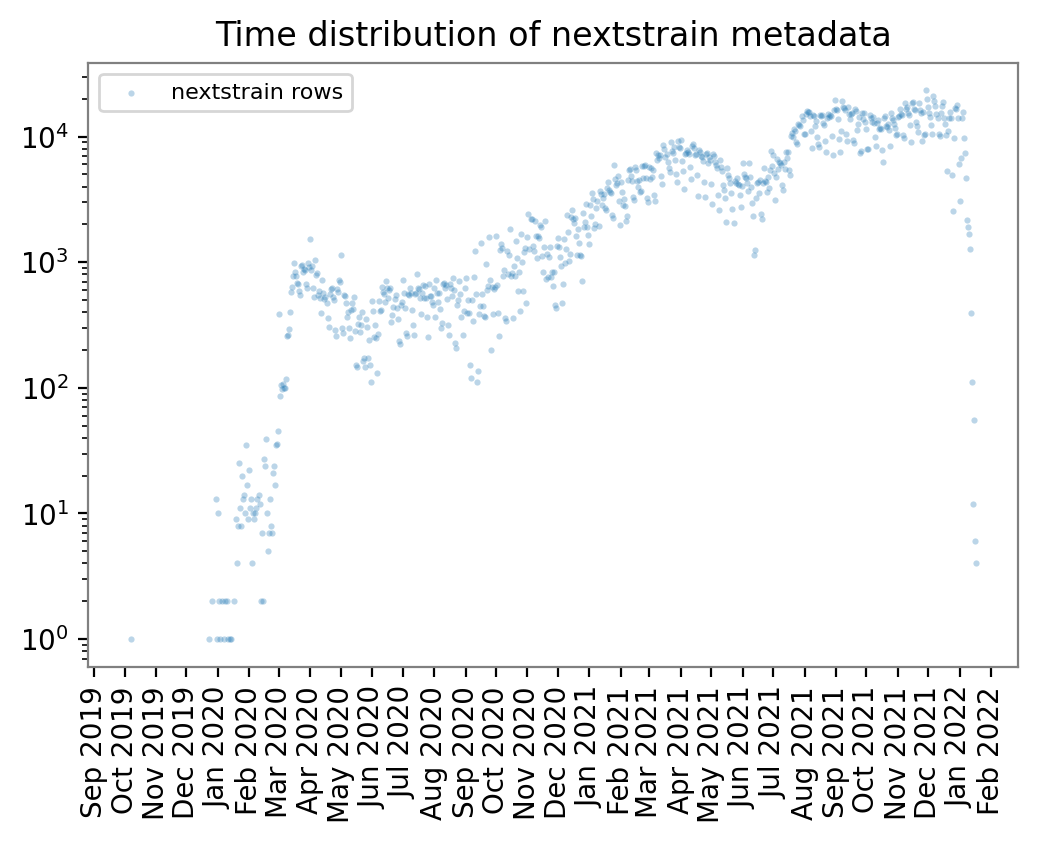

In [18]:
plt.figure(figsize=(6, 4))

# Plot nextstrain samples
start = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
step = datetime.timedelta(days=1)
X = [start + step * x for x in list(days)]
Y = list(days.values())
plt.scatter(X, Y, s=5, lw=0, alpha=0.3, label="nextstrain rows")

# Plot skipped rows.
XYs = {}
for (reason, x), y in stats["skipped_by_day"].items():
    X, Y = XYs.setdefault(reason, ([], []))
    X.append(start + step * x)
    Y.append(y)
for reason, (X, Y) in XYs.items():
    plt.scatter(X, Y, s=5, lw=0, label=reason)
    
plt.yscale("log")
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %Y"))
plt.xticks(rotation=90)
plt.legend(loc="best", fontsize=8)
plt.title("Time distribution of nextstrain metadata");

In [19]:
numer = Counter()
denom = Counter()
orphan = Counter()
for row in tqdm.tqdm(df.itertuples(), total=len(df)):
    if not isinstance(row.date, str):
        continue
    day = try_parse_date(row.date)
    if day is None:
        continue
    denom[day] += 1
    if isinstance(row.genbank_accession, str) and row.genbank_accession:
        numer[day] += 1
ratio = {k: numer[k] / v for k, v in denom.items()}

100%|███████████████████████████████████████████████████████████████████| 3722948/3722948 [00:54<00:00, 68313.27it/s]


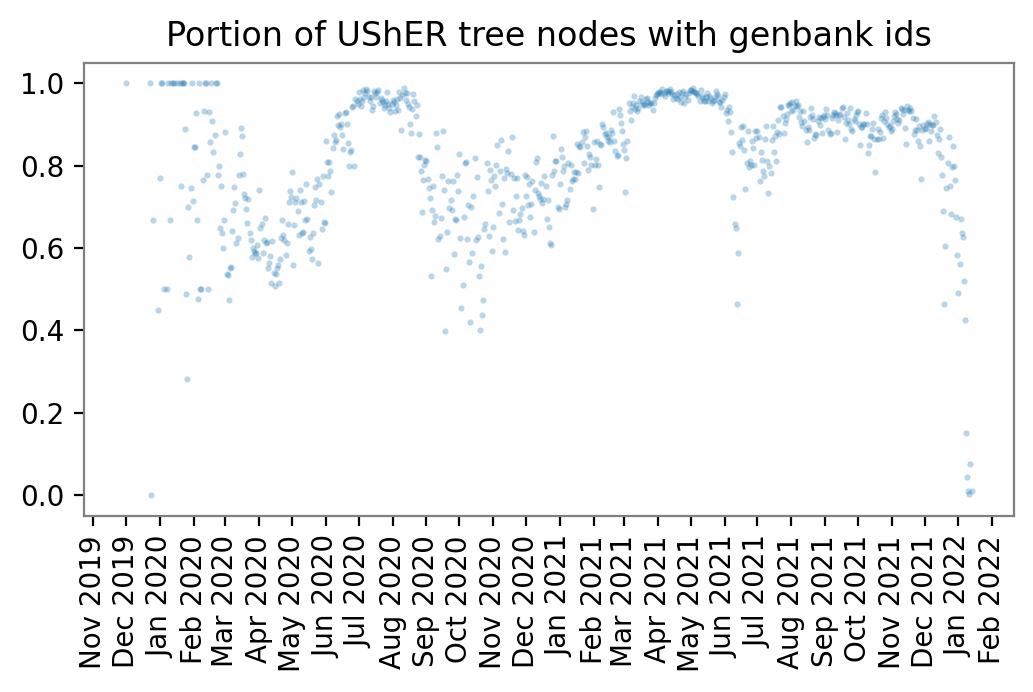

In [20]:
plt.figure(figsize=(6, 3))
plt.scatter(list(ratio), list(ratio.values()), s=5, lw=0, alpha=0.3)    
#plt.yscale("log")
ax = plt.gca()
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%b %Y"))
plt.xticks(rotation=90)
plt.title("Portion of UShER tree nodes with genbank ids");

In [21]:
orphans = df[df.isnull()["genbank_accession"]]
orphans

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher
23152,CHN/Beijing_BJ0613-09-Y/2020|GWHANPB01000001|2...,NaN,2020-06-12,China,Homo sapiens,Complete,29848,20B,B.1.1,20B,B.1.1
23153,CHN/Beijing_BJ0613-12-HJ/2020|GWHANPA01000001|...,NaN,2020-06-12,China,Environment,Complete,29858,20B,B.1.1,20B,B.1.1
23154,CHN/Beijing_BJ0617-01-Y/2020|GWHANPC01000001|2...,NaN,2020-06-14,China,Homo sapiens,Complete,29903,20B,B.1.1,20B,B.1.1
23155,CHN/Beijing_IME-BJ01/2020|GWHACAX01000001|2020...,NaN,2020-01-24,China,Homo sapiens,Complete,29872,19B,A,19B,A
23157,CHN/Beijing_IME-BJ02/2020|GWHACAY01000001|2020...,NaN,2020-01-25,China,Homo sapiens,Complete,29828,19B,A,19B,A
...,...,...,...,...,...,...,...,...,...,...,...
3719186,Wuhan_YB012504/human/2020/CHN|GWHACDJ01000001|...,NaN,2020-01-25,China,Homo sapiens,Complete,29865,19A,B,19A,B
3719187,Wuhan_YB012506/human/2020/CHN|GWHACDI01000001|...,NaN,2020-01-25,China,Homo sapiens,Complete,29866,19A,B,19A,B
3719188,Wuhan_YB012602/human/2020/CHN|GWHACDH01000001|...,NaN,2020-01-26,China,Homo sapiens,Complete,29864,19A,B,19A,B
3719189,Wuhan_YB012605/human/2020/CHN|GWHACDG01000001|...,NaN,2020-01-26,China,Homo sapiens,Complete,29861,19A,B,19A,B


In [22]:
orphans.sort_values(by="date", ascending=False)

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher
847803,England/MILK-322AB13/2022|2022-01-13,NaN,2022-01-13,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
847954,England/MILK-323096B/2022|2022-01-13,NaN,2022-01-13,England,NaN,NaN,NaN,21L (Omicron),BA.2,21M (Omicron),BA.2
844713,England/MILK-31CD90A/2022|2022-01-13,NaN,2022-01-13,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
847809,England/MILK-322ABAA/2022|2022-01-13,NaN,2022-01-13,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
847808,England/MILK-322AB9B/2022|2022-01-13,NaN,2022-01-13,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
...,...,...,...,...,...,...,...,...,...,...,...
1066468,England/PHEC-YYBHFSW/2021|,NaN,NaN,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
1094487,England/PHEP-YYDKEHE/2021|,NaN,NaN,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
1321570,England/QEUH-3175901/2021|,NaN,NaN,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1
1323188,England/QEUH-31CFDB1/2021|,NaN,NaN,England,NaN,NaN,NaN,21K (Omicron),BA.1,21K (Omicron),BA.1.1


In [23]:
ids = orphans["strain"].tolist()

In [24]:
import re
Counter(re.split(r"[/|_]", x)[0] for x in ids).most_common()

[('England', 261150),
 ('Wales', 127415),
 ('Northern', 38506),
 ('Scotland', 28312),
 ('NorthernIreland', 3380),
 ('Guangzhou', 147),
 ('Wuhan', 63),
 ('Weifang', 20),
 ('CHN', 11),
 ('Fuyang', 1),
 ('Gilgit1', 1),
 ('Hangzhou', 1),
 ('ICDC-DT005', 1),
 ('WH01', 1),
 ('WH03', 1),
 ('WH04', 1),
 ('WIV02', 1),
 ('WIV04', 1),
 ('WIV05', 1),
 ('WIV06', 1),
 ('WIV07', 1)]

In [25]:
Counter(orphans["country"]).most_common()

[('England', 261150),
 ('Wales', 127415),
 ('Northern Ireland', 41886),
 ('Scotland', 28312),
 ('China', 252),
 ('Pakistan', 1)]

In [26]:
from pyrocov.geo import get_canonical_location_generator
get_canonical_location = get_canonical_location_generator()
locations = Counter()
for row in tqdm.tqdm(df2.itertuples(), total=len(df2)):
    location = get_canonical_location(
        row.strain, row.region, row.country, row.division, row.location
    )
    locations[location] += 1

100%|██████████████████████████████████████████████████████████████████| 3464352/3464352 [00:33<00:00, 104660.48it/s]


In [27]:
locations.most_common()

[('Europe / United Kingdom / England', 1133177),
 ('North America / USA / CA', 279972),
 ('North America / USA / CO', 139269),
 ('Europe / United Kingdom / Scotland', 129262),
 ('North America / USA / FL', 114289),
 ('North America / USA / MA', 113079),
 ('Europe / Switzerland', 99147),
 ('North America / USA / MN', 97755),
 ('North America / USA / TX', 83966),
 ('Europe / Germany / North Rhine Westphalia', 73558),
 ('North America / USA / WA', 58782),
 ('North America / USA / MI', 55809),
 ('North America / USA / UT', 50425),
 ('North America / USA / NJ', 46052),
 ('Europe / Germany / Baden-Wuerttemberg', 44918),
 ('North America / USA / NC', 44469),
 ('North America / USA / PA', 43912),
 ('North America / USA / NY', 41232),
 ('North America / USA / GA', 40427),
 ('North America / USA / AZ', 38701),
 ('North America / USA / IL', 35591),
 ('Europe / Germany / Bavaria', 31001),
 ('North America / USA / OH', 28662),
 ('North America / USA / VA', 27660),
 ('North America / USA / TN', 2747

## Comparison with the usher tree

In [28]:
from pyrocov.external.usher import parsimony_pb2
from Bio.Phylo.NewickIO import Parser, Writer

with open("results/usher/all.masked.pb", "rb") as f:
    proto = parsimony_pb2.data.FromString(f.read())
tree = next(Parser.from_string(proto.newick).parse())

In [29]:
dir(proto)

['ByteSize',
 'Clear',
 'ClearExtension',
 'ClearField',
 'CopyFrom',
 'DESCRIPTOR',
 'DiscardUnknownFields',
 'Extensions',
 'FindInitializationErrors',
 'FromString',
 'HasExtension',
 'HasField',
 'IsInitialized',
 'ListFields',
 'MergeFrom',
 'MergeFromString',
 'ParseFromString',
 'RegisterExtension',
 'SerializePartialToString',
 'SerializeToString',
 'SetInParent',
 'UnknownFields',
 'WhichOneof',
 '_CheckCalledFromGeneratedFile',
 '_SetListener',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_extensions_by_name',
 '_extensions_by_number',
 'condensed_nodes',
 'metadata',
 'newick',
 'node_mutations']

In [30]:
print(len(proto.condensed_nodes))
print(proto.condensed_nodes[:10])

0
[]


In [31]:
strains = set(df2["strain"])

In [32]:
"Switzerland/LU-DIA-011424153001/2021|OU755170.1|2021-09-01" in strains

False

In [33]:
"Switzerland/LU-DIA-011424153001/2021" in strains

True

In [34]:
Counter(bool(node.name) for node in tree.find_clades())

Counter({False: 784007, True: 3749916})

## Phylogenetic distribution of samples in pruned trees

In [35]:
%%time
with open(f"results/columns.pkl", "rb") as f:
    columns = pickle.load(f)
clade_counts = {}
for max_num_clades in [2000, 3000, 5000, 10000]:
    filename = f"results/columns.{max_num_clades}.pkl"
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            counts = Counter(pickle.load(f)["clade"])
            clade_counts[max_num_clades] = counts
            print((max_num_clades, len(counts)))

(2000, 2000)
(3000, 2999)
(5000, 4999)
(10000, 9995)
CPU times: user 9.36 s, sys: 4.1 s, total: 13.5 s
Wall time: 14.7 s


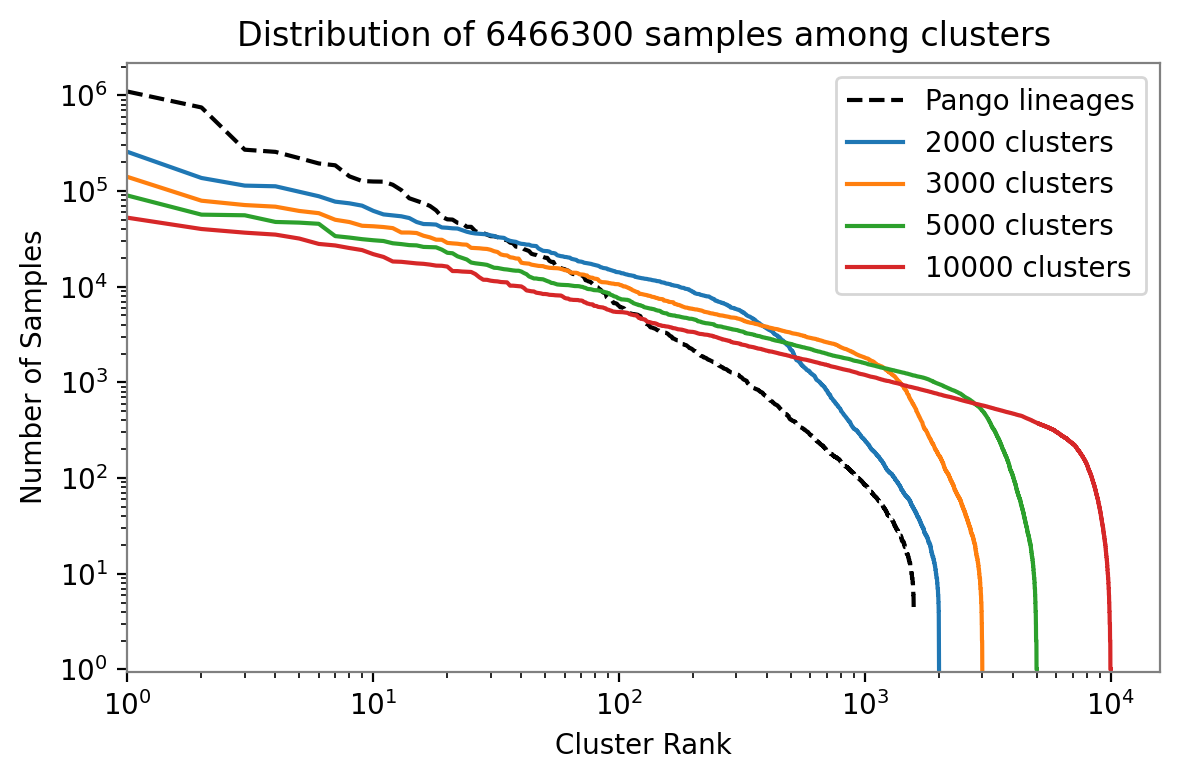

In [36]:
strain_counts = Counter(columns["lineage"])
plt.figure(figsize=(6,4))
Y = [c for _, c in strain_counts.most_common()]
plt.plot(torch.arange(1,1 + len(Y)), Y, "k--", label="Pango lineages")
for k, v in clade_counts.items():
    Y = [c for _, c in v.most_common()]
    plt.plot(torch.arange(1,1 + len(Y)), Y, label=f"{k} clusters")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1, None)
plt.ylim(0.95, None)
plt.xlabel("Cluster Rank")
plt.ylabel("Number of Samples")
plt.legend(loc="upper right")
plt.title(f"Distribution of {len(columns['lineage'])} samples among clusters")
plt.tight_layout()
plt.savefig("paper/clade_distribution.png")

In [37]:
print({k: len(v) for k, v in clade_counts.items()})

{2000: 2000, 3000: 2999, 5000: 4999, 10000: 9995}


In [38]:
print({k: len(v) for k, v in columns.items()})

{'clade': 6466300, 'index': 6466300, 'day': 6466300, 'location': 6466300, 'lineage': 6466300}


In [39]:
columns.keys()

dict_keys(['clade', 'index', 'day', 'location', 'lineage'])

In [40]:
columns["day"][:10]

[96, 78, 125, 115, 111, 115, 117, 114, 131, 117]

In [41]:
with open("results/columns.2000.pkl", "rb") as f:
    columns2000 = pickle.load(f)

In [42]:
{k: len(v) for k, v in columns.items()}

{'clade': 6466300,
 'index': 6466300,
 'day': 6466300,
 'location': 6466300,
 'lineage': 6466300}

In [43]:
{k: len(v) for k, v in columns2000.items()}

{'clade': 6466300,
 'index': 6466300,
 'day': 6466300,
 'location': 6466300,
 'lineage': 6466300}

In [44]:
print(sum(1 for clade in tree.find_clades()))
print(sum(bool(clade.name) for clade in tree.find_clades()))

4533923
3749916


In [45]:
if proto.condensed_nodes:
    print(list(proto.condensed_nodes[0].condensed_leaves))

## Exploring a larger tree

In [46]:
%%time
proto, tree = load_proto("results/gisaid/gisaidAndPublic.masked.pb.gz")
print(len(proto.metadata))

4833238
CPU times: user 1min 37s, sys: 1min 27s, total: 3min 4s
Wall time: 3min 56s


In [47]:
condensed_nodes = {}
for node in proto.condensed_nodes:
    condensed_nodes[node.node_name] = list(node.condensed_leaves)
print(len(condensed_nodes))
print(sum(map(len, condensed_nodes.values())))

926211
4792935


In [48]:
strains = set()
gisaids = set()
for node in tqdm.tqdm(tree.find_clades(), total=len(proto.metadata)):
    if node.name:
        for name in condensed_nodes.get(node.name, [node.name]):
            strains.add(name)
            match = re.search(r"\bEPI_ISL_[0-9]+\b", name)
            if match:
                gisaids.add(match.group(0))
print(len(strains), len(gisaids))

100%|███████████████████████████████████████████████████████████████████| 4833238/4833238 [01:08<00:00, 70723.73it/s]

7140401 3487191


In [49]:
strain_to_gisaid = {}
with open("results/gisaid/epiToPublicAndDate.latest", "rt") as f:
    for line in f:
        row = line.strip().split()
        if row:
            strain_to_gisaid[row[1]] = row[0]
print(len(strain_to_gisaid))

3558478


## Do PANGO lineages respect the finer tree order?

In [50]:
features = torch.load("results/features.3000.1.pt")
lineage_to_clade = features["lineage_to_clade"]
clade_to_lienage = features["clade_to_lineage"]

In [51]:
for lineage, clade in lineage_to_clade.items():
    p = pangolin.get_parent(pangolin.decompress(lineage))
    if p is None:
        continue
    p = pangolin.compress(p)
    c = lineage_to_clade.get(p)
    if c is None:
        continue
    if not clade.startswith(c + "."):
        print(p, lineage, "\n", c, "\n", clade)

A B 
 fine.492.11 
 fine
B.1 B.1.14 
 fine.521.0.. 
 fine.15
A A.27 
 fine.492.11 
 fine.155...0.0.0.0.0
B.1.1 B.1.1.161 
 fine.521.0...1283.. 
 fine.395.43....
A.2 A.2.5 
 fine.492.11.44.1.0 
 fine.492.11.44.1.1.0..0.0..0
A.23 A.23.1 
 fine.492.11.48.3.37.23.24.1.90.0..0.0..0.31.0 
 fine.492.11.48.3.37.23.24.1.90.0.
B.1.214 B.1.214.1 
 fine.521.0...213.533.7. 
 fine.521.0...213.533.7.0.
B.1.214 B.1.214.3 
 fine.521.0...213.533.7. 
 fine.521.0...213.533.7.1..1..
B.1.214 B.1.214.4 
 fine.521.0...213.533.7. 
 fine.521.0...213.533.7.1..2..
B.1.1 B.1.1.291 
 fine.521.0...1283.. 
 fine.521.0...439.0..3.
B.1.1 B.1.1.290 
 fine.521.0...1283.. 
 fine.521.0...439.0..3..61.2.7.1
B.1.617 B.1.617.3 
 fine.521.0...472.0.......1.3. 
 fine.521.0...472.0.......0..
B.1.617 B.1.617.2 
 fine.521.0...472.0.......1.3. 
 fine.521.0...472.0.......1.0..
B.1.415 B.1.415.1 
 fine.521.0...1260.672.0 
 fine.521.0...548.2...0..0
B.1.258 B.1.258.2 
 fine.521.0...1260..225.13.0.0.4..0 
 fine.521.0...1260..225.13.0.0